In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We implement LSTM following the implementation of Krish Naik from the following sources: 
# references:https://github.com/krishnaik06/Fake-New-LSTM/blob/master/FakeNewsClassifierUsingLSTM.ipynb
# https://github.com/krishnaik06/Handle-Imbalanced-Dataset/blob/master/Handling%20Imbalanced%20Data-%20Under%20Sampling.ipynb
# reference: https://github.com/krishnaik06/Handle-Imbalanced-Dataset/blob/master/Handling%20Imbalanced%20Data-%20Under%20Sampling.ipynb
# https://www.freecodecamp.org/news/install-tensorflow-and-keras-using-anaconda-navigator-without-command-line/
# Ref:https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python


In [3]:

df=pd.read_csv("C:\\Users\\sabbi\\Dropbox\\NLP\\input_data\\complaints-2021-03-29_17_28.csv")
df.head()
#df['Product'].unique() # credit card data only




,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/15/16,Credit card,None,Application processing delay,None,NaN,None,FIRSTBANK PUERTO RICO,PR,00987,None,Consent not provided,Web,05/12/16,Closed,Yes,Yes,1881274
1,12/16/15,Credit card,None,Sale of account,None,NaN,None,HSBC NORTH AMERICA HOLDINGS INC.,NY,148XX,None,NaN,Phone,12/17/15,Closed with explanation,Yes,No,1705689
2,06/11/12,Credit card,None,Customer service / Customer relations,None,NaN,None,JPMORGAN CHASE & CO.,FL,33029,None,NaN,Web,06/13/12,Closed with explanation,Yes,Yes,99187
3,01/25/14,Credit card,None,Closing/Cancelling account,None,NaN,None,HSBC NORTH AMERICA HOLDINGS INC.,MD,212XX,None,NaN,Web,01/24/14,Closed with explanation,Yes,No,683347
4,03/23/15,Credit card,None,Identity theft / Fraud / Embezzlement,None,NaN,None,CAPITAL ONE FINANCIAL CORPORATION,FL,33324,Older American,NaN,Phone,03/24/15,Closed with explanation,Yes,Yes,1295234


In [4]:
#keeps only the relevant columns

df=df[['Consumer disputed?','Consumer complaint narrative']]
df.rename({'Consumer disputed?':'Dispute', 'Consumer complaint narrative': 'Narrative'},axis=1,inplace=True)
df.isnull().values.any()
df=df.dropna()
df.reset_index(drop=True, inplace=True)
df.head()


,Dispute,Narrative
0,No,My discover card statement was automatically d...
1,No,"Earlier this month, I set up an electronic pay..."
2,Yes,"XXXX XXXX, 2016 To Whom It May Concern : I 'm ..."
3,Yes,I have rented a car XXXX and paid the rental a...
4,No,I was shocked when I reviewed my credit report...


[0.23, 0.77]


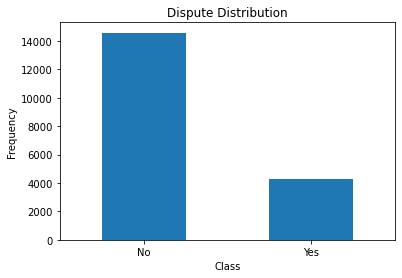

In [5]:
#checks class balance

count_classes=pd.value_counts(df['Dispute'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Dispute Distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency")

class_proportion = [round(sum(df['Dispute']=='Yes')/(sum(df['Dispute']=='Yes') + sum(df['Dispute']=='No')),2), round(sum(df['Dispute']=='No')/(sum(df['Dispute']=='Yes') + sum(df['Dispute']=='No')),2) ]
print(class_proportion)

# Yes_data=df[df['Dispute']=='Yes']
# Yes_data.reset_index(drop=True, inplace=True)
# No_data=df[df['Dispute']=='No']
# No_data.reset_index(drop=True, inplace=True)


In [6]:
# sample 1000 rows from the total data set for train
#train_data = df.sample(n=5000,replace=False)
train_data = df.copy()
train_data = train_data[0:18000]
train_data.reset_index(drop=True, inplace=True)

class_proportion = [round(sum(train_data['Dispute']=='Yes')/(sum(train_data['Dispute']=='Yes') + sum(train_data['Dispute']=='No')),2), round(sum(train_data['Dispute']=='No')/(sum(train_data['Dispute']=='Yes') + sum(train_data['Dispute']=='No')),2) ]
print(class_proportion)

# sampling a real test data
test_data = df.copy()
test_data = test_data[18000:18838]
test_data.reset_index(drop=True, inplace=True)

class_proportion = [round(sum(test_data['Dispute']=='Yes')/(sum(test_data['Dispute']=='Yes') + sum(test_data['Dispute']=='No')),2), round(sum(test_data['Dispute']=='No')/(sum(test_data['Dispute']=='Yes') + sum(test_data['Dispute']=='No')),2) ]
print(class_proportion)

print(len(train_data))
print(len(test_data))

[0.23, 0.77]
[0.23, 0.77]
18000
838


In [7]:
#Renames the vars

X=train_data.drop('Dispute', axis=1)
y=train_data['Dispute'].map({'Yes':1, 'No':0})

messages=X.copy()

#printing the 4th complaint
#print(messages['Narrative'][4]) #printing the first complaint

X_t=test_data.drop('Dispute', axis=1)
y_t=test_data['Dispute'].map({'Yes':1, 'No':0})

messages_t=X_t.copy()

#print(messages_t['Narrative'][2]) #printing the first complaint

print(len(messages))
print(len(messages_t))


18000
838


In [8]:
import nltk
import re
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()


In [9]:
corpus=[]

contractions=re.compile(r"'|-|\"") #ref: Matt Taddy BDS
symbols=re.compile(r'(\W+)', re.U)
singles=re.compile(r'(\s\S\s)', re.I | re.U)
seps=re.compile(r'\s+')
special=['XXXX','xxxx','XX','xx','XXX','xxx','XXXXX','xxxxx']
pattern= '['+''.join(special)+']' #ref:https://thispointer.com/python-remove-characters-from-string-by-regex-4-other-ways/


In [10]:
#get tensorflow
#https://www.freecodecamp.org/news/install-tensorflow-and-keras-using-anaconda-navigator-without-command-line/

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense 

for i in range (0, len(messages)):
    #print(i)
    complaint=re.sub('[^a-zA-Z]',' ', messages['Narrative'][i])
    complaint=complaint.lower()
    #complaint=contractions.sub('', complaint)
    #complaint=symbols.sub(r' \1', complaint)
    #complaint=singles.sub(' ', complaint)
    #complaint=seps.sub(' ', complaint)
    complaint=re.sub(pattern,'', complaint)
    complaint=complaint.split()
     
    complaint=[ps.stem(word) for word in complaint if not word in stopwords.words('english')]
    complaint=' '.join(complaint)
    corpus.append(complaint)
 

C:\Users\sabbi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sabbi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sabbi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sabbi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [11]:
#corpus_t=[]
for i in range (0, len(messages_t)):
    #print(i)
    complaint_t=re.sub('[^a-zA-Z]',' ', messages_t['Narrative'][i])
    complaint_t=complaint_t.lower()
    #complaint=contractions.sub('', complaint)
    #complaint=symbols.sub(r' \1', complaint)
    #complaint=singles.sub(' ', complaint)
    #complaint=seps.sub(' ', complaint)
    complaint_t=re.sub(pattern,'', complaint_t)
    complaint_t=complaint_t.split()
     
    complaint_t=[ps.stem(word) for word in complaint_t if not word in stopwords.words('english')]
    complaint_t=' '.join(complaint_t)
    corpus.append(complaint_t)


In [12]:
#printing the 10th complaint
print(corpus[2]) #printing the first complaint
print(len(corpus[2]))


may concern outrag us bank debit account without author credit card payment complet etern transfer respect us bank credit card howev notic check account doubl post us bank total immedi call spoke repres confirm mistak system epect refund four day call three time spoke sever repres state money held day return also left voic mail special payment research depart yet receiv phone call back unaccept money held us bank make interest week fund need return bank account immedi interest look fast resolut fund return soon possibl
524


In [13]:
voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus]  # How does voc_size work here??
print(onehot_repr[2])
print(len(onehot_repr[2]))


[2517, 3234, 905, 145, 4656, 1495, 393, 2165, 2435, 702, 607, 4989, 819, 2731, 8, 3233, 145, 4656, 702, 607, 4260, 4719, 1684, 393, 2314, 2762, 145, 4656, 2143, 4767, 3056, 1555, 2418, 1608, 348, 1512, 4227, 4553, 576, 4825, 3056, 1249, 387, 1555, 4584, 2418, 516, 4291, 4213, 4825, 2489, 2676, 1026, 2964, 3438, 1732, 4989, 1334, 138, 4372, 3900, 1189, 3056, 4829, 346, 4291, 4213, 145, 4656, 1697, 4263, 3454, 4244, 946, 2489, 4656, 393, 4767, 4263, 4439, 4014, 3103, 4244, 2489, 3670, 3263]
86


In [14]:
sent_length=100
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)


In [15]:

## Creating model
embedding_vector_features=40 # What does this number do? Does it 
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 40)           200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [16]:

import numpy as np
X_final=np.array(embedded_docs.copy())
X_final=(X_final[0:18000])
y_final=np.array(y[0:18000])

#X_final.shape
#y_final.shape

X_final_t=np.array(embedded_docs.copy())
X_final_t=(X_final_t[18000:18838])
y_final_t=np.array(y_t)


In [17]:

from imblearn.under_sampling import NearMiss
# alpha01 = no of minority class / no of majority class
# alpha01 = 1
nm=NearMiss(sampling_strategy='majority')

X_res, y_res=nm.fit_resample(X_final, y_final)

#print(X_res.shape)
#print(y_res.shape)
class_proportion = [sum(y_res==1)/len(y_res), sum(y_res==0)/len(y_res)]
print(class_proportion)

[0.5, 0.5]


In [18]:

from collections import Counter
print('Original dataset shape {}'.format(Counter(y_final)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)



Original dataset shape Counter({0: 13936, 1: 4064})
Resampled dataset shape Counter({0: 4064, 1: 4064})


In [19]:
### Finally Training
performance=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)
y_pred=model.predict_classes(X_test)


Train on 6096 samples, validate on 2032 samples
Epoch 1/20
6096/6096 [==============================] - 27s 4ms/sample - loss: 0.4505 - acc: 0.7920 - val_loss: 0.3350 - val_acc: 0.8652
Epoch 2/20
6096/6096 [==============================] - 30s 5ms/sample - loss: 0.3351 - acc: 0.8632 - val_loss: 0.3307 - val_acc: 0.8661
Epoch 3/20
6096/6096 [==============================] - 29s 5ms/sample - loss: 0.3125 - acc: 0.8716 - val_loss: 0.3339 - val_acc: 0.8637
Epoch 4/20
6096/6096 [==============================] - 27s 4ms/sample - loss: 0.2891 - acc: 0.8835 - val_loss: 0.3395 - val_acc: 0.8573
Epoch 5/20
6096/6096 [==============================] - 28s 5ms/sample - loss: 0.2607 - acc: 0.8967 - val_loss: 0.3405 - val_acc: 0.8573
Epoch 6/20
6096/6096 [==============================] - 28s 5ms/sample - loss: 0.2294 - acc: 0.9072 - val_loss: 0.3869 - val_acc: 0.8317
Epoch 7/20
6096/6096 [==============================] - 28s 5ms/sample - loss: 0.2060 - acc: 0.9183 - val_loss: 0.4028 - val_acc: 

In [20]:
y_pred_t=model.predict_classes(X_final_t)

In [21]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)


array([[760, 234],
       [155, 883]], dtype=int64)

In [22]:
confusion_matrix(y_final_t,y_pred_t)

array([[147, 499],
       [ 36, 156]], dtype=int64)

In [23]:

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))
#print(len(performance.history['acc']))
#print(len(performance.history['val_acc']))
print(accuracy_score(y_final_t,y_pred_t))


0.8085629921259843
0.3615751789976134


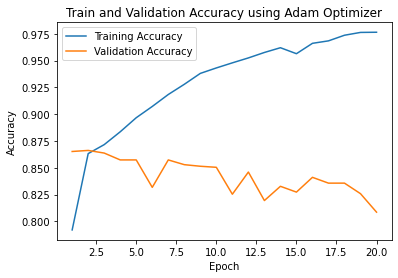

In [24]:

# Plot accuracy per epoch
plt.plot(range(1,len(performance.history['acc'])+1), performance.history['acc'], label='Training Accuracy') 
plt.plot(range(1,len(performance.history['val_acc'])+1), performance.history['val_acc'], label='Validation Accuracy')
#plt.axis([1, 2, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using Adam Optimizer')
plt.legend()
plt.show()




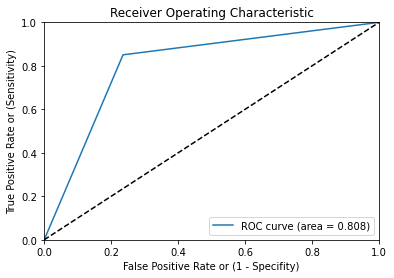

In [25]:

#plots ROC
#Ref:https://stackoverflow.com/questions/34564830/roc-curve-with-sklearn-python
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


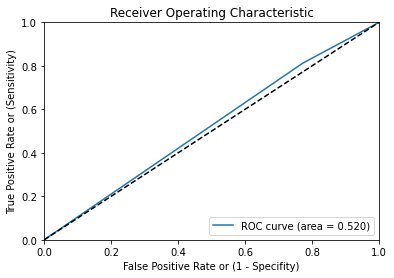

In [26]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_final_t,y_pred_t)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [27]:

# from tensorflow.keras.layers import Dropout
# ## Creating model
# embedding_vector_features=40
# model=Sequential()
# model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [28]:

# expe=messages.head()  

# for i in range (0, len(expe)):
#     print(i)
#     complaint=re.sub('[^a-zA-Z]',' ', expe['Narrative'][3])
#     #complaint=expe['Narrative'][i].lower()
#     #complaint=contractions.sub('', complaint)
#     #complaint=symbols.sub(r' \1', complaint)
#     #complaint=singles.sub(' ', complaint)
#     #complaint=seps.sub(' ', complaint)
#     complaint=re.sub(pattern,'', complaint)
    
        
#     #complaint= complaint.lower()
#     complaint=complaint.split()
     
#     complaint=[ps.stem(word) for word in complaint if not word in stopwords.words('english')]
#     complaint=' '.join(complaint)
#     corpus.append(complaint)
